# **CLICKBAIT CLASSIFIER**
***

[Dataset](https://www.kaggle.com/datasets/amananandrai/clickbait-dataset?select=clickbait_data.csv)

In [96]:
# ML-related external modules
import nltk
import keras.layers
import numpy as np
import pandas as pd
import matplotlib as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Embedding, GlobalAvgPool1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.backend import clear_session
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from numpy import asarray
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# non-ML related external modules
import contractions
import latexify

# built-in modules
from collections import Counter
from importlib import reload
import time
import re
import random
import string
from string import punctuation
import math
import csv

#local files
import preprocessor
import grapher
import encode
import df_helper

In [97]:
# important paths
DATASETS = 'Datasets\\'
SAVED_MODELS = 'Saved Models\\'

## LOAD DATA
- create aggregate dataset from all datasets for model training

In [98]:
# load data from csv into dataframe
file1 = 'Datasets\\clickbait_data.csv'
file2 = 'Datasets\\clickbait_data2.csv'
file3 = 'Datasets\\news_data.csv'

f1_content = pd.read_csv(file1)
f2_content = pd.read_csv(file2, usecols=['title'])
f3_content = pd.read_csv(file3, usecols=['headline_text'], nrows=f2_content.shape[0] - 2)

df1 = pd.DataFrame(f1_content)
df1.rename(columns={'clickbait': 'label'}, inplace=True)

df2 = pd.DataFrame(f2_content)
df2.rename(columns={'title': 'headline'}, inplace=True)

df3 = pd.DataFrame(f3_content)
df3.rename(columns={'headline_text' : 'headline'}, inplace=True)

In [99]:
f1_content.shape, f2_content.shape, f3_content.shape

((32000, 2), (4978, 1), (4976, 1))

In [100]:
# add label columns to df2 and df3
df2['label'] = 1
df3['label'] = 0

In [101]:
# aggregate data
agg_df = pd.concat([df1, df2, df3], ignore_index=True)
agg_df.shape

(41954, 2)

In [102]:
# check for missing entries
agg_df['headline'].isna().sum()

0

In [103]:
# check distribution of labels
agg_df['label'].value_counts()

1    20977
0    20977
Name: label, dtype: int64

In [104]:
# preview uncleaned dataset, and save uncleaned
# uncleaned_data = agg_df.to_csv(DATASETS + 'aggregate_data.csv', encoding='utf-8')
agg_df

,headline,label
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
41949,port kembla steelworks fire extinguished,0
41950,portrait of terror sheikh as a young man,0
41951,protesters target pm at centre funding announc...,0
41952,push on for leagues club changes,0


In [105]:
# define label column
y = agg_df['label'].astype(np.float32)

## **PRE-PROCESSING**
- clean data
    - convert to lowercase
    - expand contractions (handle exceptions)
    - remove punctuation (keep hyphens)
    - remove stop words *(optional)*
    - adjust spacing as needed

In [106]:
cleaned: DataFrame = preprocessor.clean_data(agg_df, remove_sw=True)
agg_df.headline = cleaned
cleaned.head()

0                                            get bings
1                        tv female friend group belong
2      new star wars force awakens trailer give chills
3    vine new york celebrity big brother fucking pe...
4    couple stunning photo shoot baby learning inop...
Name: headline, dtype: object

In [107]:
# saved cleaned dataset
# cleaned_data = cleaned.to_csv(DATASETS + 'cleaned_data.csv', encoding='utf-8')

## Splitting the Dataset
- split cleaned data into training and test sets

In [108]:
train_data, test_data, y_tr, y_te = train_test_split(cleaned, y, test_size=0.2, random_state=3)
y_tr = y_tr.astype(np.float32)
y_te = y_te.astype(np.float32)

### **ENCODING**
- obtain doc-term matrix of corpus
- obtain vocab list

In [109]:
# X_train is a document-term matrix (sparse matrix)
reload(encode)
cv = CountVectorizer()
cv.fit(train_data)
vocab = cv.get_feature_names()
X_tr = cv.transform(train_data)
X_tr = X_tr.toarray()
X_te = cv.transform(test_data)
X_te = X_te.toarray()
vocab, X_tr.shape, X_te.shape

(['00',
  '000',
  '000th',
  '00s',
  '04',
  '05',
  '08',
  '08m',
  '09',
  '10',
  '100',
  '1000',
  '10000',
  '100000',
  '10000th',
  '1000blackgirls',
  '100m',
  '100th',
  '101',
  '101st',
  '102',
  '103',
  '1035',
  '104',
  '105',
  '106',
  '106m',
  '108',
  '109',
  '109th',
  '10m',
  '10th',
  '11',
  '110',
  '112pc',
  '113',
  '114',
  '115',
  '116',
  '118th',
  '11k',
  '11pc',
  '11th',
  '12',
  '120',
  '1200',
  '121',
  '1215',
  '122',
  '123',
  '124',
  '127',
  '12b',
  '12th',
  '13',
  '130',
  '132',
  '134',
  '137',
  '139',
  '13th',
  '14',
  '140',
  '147',
  '149',
  '14m',
  '14th',
  '15',
  '150',
  '1502',
  '152',
  '153',
  '155',
  '155m',
  '158',
  '15bn',
  '15th',
  '16',
  '160',
  '162',
  '163',
  '165',
  '16m',
  '16th',
  '17',
  '170',
  '1700',
  '17000',
  '172',
  '174',
  '175',
  '175m',
  '177',
  '17pc',
  '17th',
  '18',
  '180',
  '18000',
  '1800s',
  '188',
  '1890s',
  '18th',
  '19',
  '1900s',
  '191',
  '191

## Building & Training the Model

In [110]:
@latexify.with_latex
def relu(x):
    if x >= 0:
        return x
    else:
        return 0
relu

<latexify.core.with_latex.<locals>._LatexifiedFunction at 0x1d91d1256d0>

In [111]:
# activation function
@latexify.with_latex
def sigmoid(x):
    return 1 / (1 + e ** -x)
sigmoid

<latexify.core.with_latex.<locals>._LatexifiedFunction at 0x1d91ca35eb0>

In [112]:
model = Sequential()
model.add(Dense(10, activation='relu', input_dim=X_tr.shape[1]))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                225850    
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 225,861
Trainable params: 225,861
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
263/263 [==============================] - 4s 12ms/step - loss: 0.4135 - accuracy: 0.9334 - val_loss: 0.2126 - val_accuracy: 0.9640
Epoch 2/20
263/263 [==============================] - 3s 11ms/step - loss: 0.1425 - accuracy: 0.9729 - val_loss: 0.1212 - val_accuracy: 0.9677
Epoch 3/20
263/263 [==============================] - 3s 11ms/step - loss: 0.0804 - accuracy: 0.9825 - val_loss: 0.0966 - val_accuracy: 0.9695
Epoch 4/20
263/263 [==============================] - 3s 11ms/step - loss: 0.0542 - accuracy: 0.9877 - val_loss: 0.0871 - val_accuracy: 0.9704
Epoch 5/20
263/263 [==============================] - 3s 12ms/step - loss: 0.0392 - accuracy: 0.9922 - val_loss: 0.0833 - val_accuracy: 0.9707
Epoch 6/20
263/263 [==============================] - 3s 11ms/step - loss: 0.0294 - accuracy: 0.9947 - val_loss: 0.0821 - val_accuracy: 0.9701
Epoch 7/20
263/263 [==============================] - 3s 11ms/step - loss: 0.0227 - accuracy: 0.9962 - val_loss: 0.0822 - val_accuracy: 0.9700

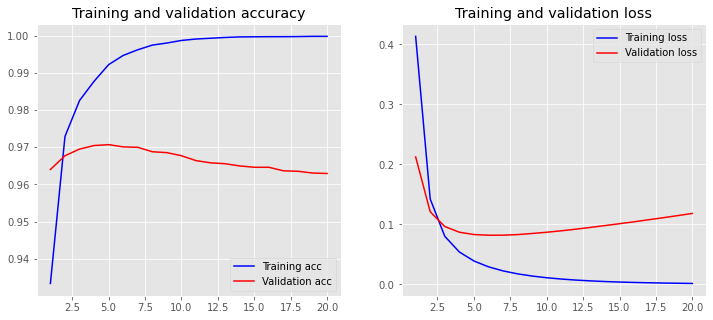

In [113]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_accuracy', patience=5)

# uncomment to train with early stopping
# history = model.fit(X_tr, y_tr,
#                     epochs=20,
#                     verbose=True,
#                     validation_data=(X_te, y_te),
#                     batch_size=128,
#                     callbacks=callback)

history = model.fit(X_tr, y_tr,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_te, y_te),
                    batch_size=128)

grapher.plot_history(history)

In [114]:
loss, accuracy = model.evaluate(X_tr, y_tr, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))

1049/1049 [==============================] - 3s 3ms/step - loss: 0.0015 - accuracy: 0.9998
Training Accuracy: 0.9998


In [115]:
loss, accuracy = model.evaluate(X_te, y_te, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))

263/263 [==============================] - 1s 3ms/step - loss: 0.1184 - accuracy: 0.9629
Testing Accuracy:  0.9629


In [116]:
# save model
# model.save('Saved Models\\trained_agg')

In [117]:
# load model
#trained_model = keras.models.load_model('Saved Models\\trained_2')

In [118]:
def clickbait_classifier():
    from_user = input()
    doc_term_matrix = encode.to_doc_term_matrix(from_user, train_data=train_data)
    pred = model.predict(doc_term_matrix, verbose=False)[0]
    if pred >= 0.5:
        print('"{}": CLICKBAIT!\n'.format(from_user))
    else:
        print('"{}": Not clickbait.\n'.format(from_user))
    return pred

In [119]:
result = clickbait_classifier()
print(result)

"15 shocking life hacks that will leave you speechless": CLICKBAIT!

[0.99999976]
